# LightGBM

부스팅 계열 알고리즘. XGBoost는 GBM보다 빠르고 매우 뛰어난 알고리즘이지만, 여전히 학습 시간이 오래 걸린다. XGBoost에서 GridSearchCV로 하이퍼 파라미터 튜닝을 수행하다 보면 시간이 너무 오래 걸려서 많은 파라미터를 튜닝해야 한다.

#### LightGBM 장점 

* XGBoost 대비 더 빠른 학습과 예측 수행 시간
* 더 작은 메모리 사용량
* 카테고리형 피처의 자동 변환과 최적 분할(원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)

#### LightGBM 단점

* 적은 데이터 세트(10000만 건 이하 정도)에 적용할 경우 과적합이 발생하기 쉽다.

#### 기존 GBM과의 차이점

일반 GBM 계열의 트리 분할 방법(균형 리프 분할)과 다르게 리프 중심 트리 분할(Leaf Wise) 방식을 사용.

* 균형 리프 분할(Level Wise)은 최대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 트리 깊이를 최소화하여 오버 피팅에 강한 구조이지만 균형을 맞추기 위한 시간이 필요
* 리프 중심 트리 분할의 경우 최대 손실값(max dalta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성된다. 이로써 예측 오류 손실을 최소화할 수 있다.

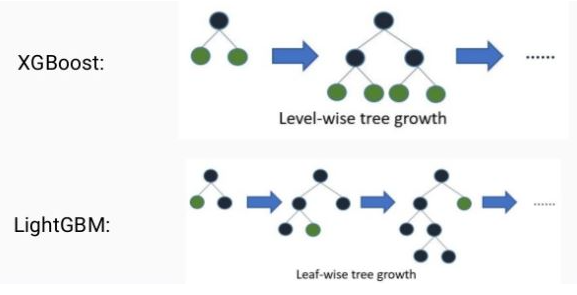

# LightGBM 하이퍼 파라미터

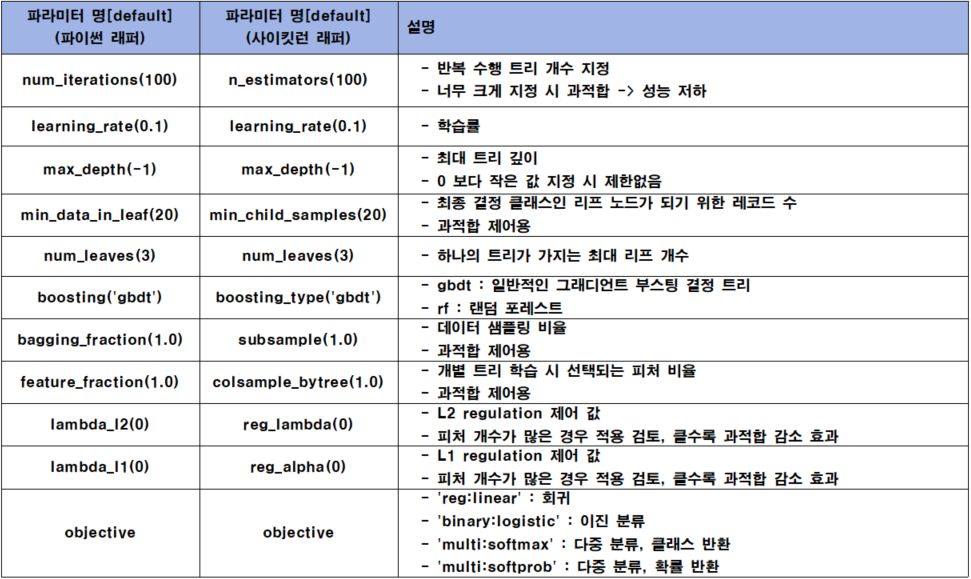

#### 하이퍼 파라미터 튜닝 방안

num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안.

* num_leaves : 개별 트리가 가질 수 있는 최대 리프 개수. 개수를 높기면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지면 모델의 복잡도가 커져 과적합 영향도도 커진다.

* min_data_in_leaf(min_child_smaples) : num_leaves와 학습 데이터 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지.

* max_depth : 깊이 크기 제한. num_leaves, min_data_in_leaf와 결합해 과적합 개선.

또한 learning_rate를 작게하면서 n_estimators를 크기하는 것을 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안.

In [ ]:
# LightGBM 적용 - 위스콘신 유방암 예측
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimator=400)

# 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {0:.4f} 정밀도 {1:.4f} 재현율 {2:.4f} F1 {3:.4f} AUC {4:.4f}\n'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도 : 0.9474 정밀도 0.9494 재현율 0.9740 F1 0.9615 AUC 0.9926



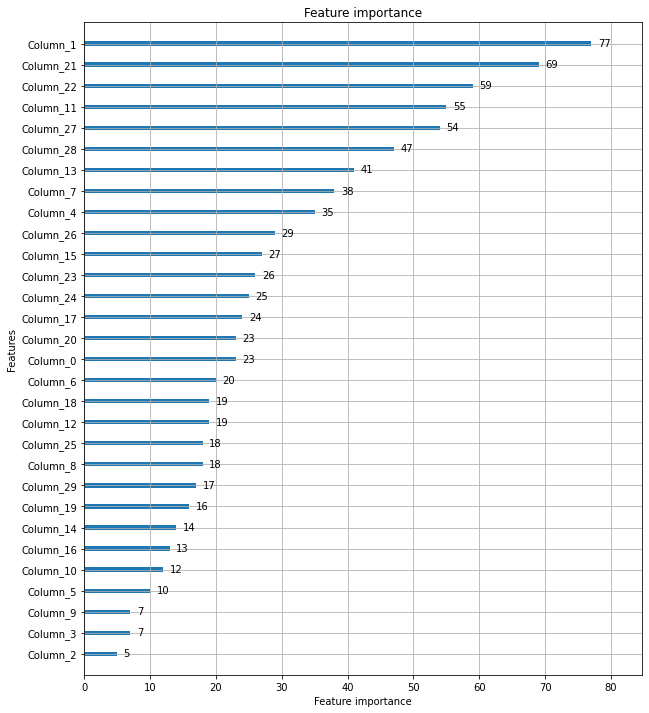

In [ ]:
# feature importance 시각화
# LightGBM의 plot_importance()
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)